# Build Model and Generate Predictions

### Load Necessary Packages

In [1]:
import os
import time
import random

import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
import re
import gc

### Create function for checking memory usage of dataframes

In [2]:
def check_memory_usage(data):
    """ Takes DataFrame as input and returns memory usage statistics. 
    """
    print ''
    print 'Checking memory usage statistics... '
    print(data.info(memory_usage=True))    

###  Create custom evaluation metric, Root Mean Log Squared Error (RMSLE)

In [3]:
def RMSLE(actuals, predictions):
    """ Takes true values and predictions. Returns their Root Mean Squared Logarithmic Error.
    """
    result = 0.0
    actuals = np.asarray(actuals) * 1.0
    predictions = np.asarray(predictions)
    if(len(actuals) == len(predictions)):
        result = np.sqrt(sum(((np.log(predictions + 1.0) - np.log(actuals + 1.0)) ** 2) / len(actuals)))
        return result
    else: 
        return "Error!"

### Set seed for reproducibility purposes

In [4]:
random.seed(0)

### Load the data

In [5]:
def load_data(): 
    """ Loads and returns train and test data. 
    """
    # Set work directory
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data') 
    
    # Load data efficiently by setting numpy data types for variables
    train_types = {
         'Semana': np.uint8, 'Agencia_ID': np.uint16
         , 'Canal_ID': np.uint8
         , 'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
         , 'Client_Type': np.uint32
         , 'short_product_name': np.uint32, 'weight': np.float32, 'pieces': np.float32, 'weight_per_piece': np.float32 
         , 'Demanda_uni_equil': np.float16
         , 'Demanda_uni_equil_tminus2': np.float16, 'Demanda_uni_equil_tminus3': np.float16
         , 'Demanda_uni_equil_tminus4': np.float16, 'Demanda_uni_equil_tminus5': np.float16  
         , 'Agencia_ID_count': np.float32, 'Canal_ID_count': np.float32, 'Ruta_SAK_count': np.float32
         , 'Cliente_ID_count': np.float32, 'Producto_ID_count': np.float32, 'Client_Type_count': np.float32
         }  
         
    test_types = {
         'Semana': np.uint8, 'Agencia_ID': np.uint16
         , 'Canal_ID': np.uint8
         , 'Ruta_SAK': np.uint16, 'Cliente_ID': np.uint32, 'Producto_ID': np.uint16
         , 'Client_Type': np.uint32
         , 'short_product_name': np.uint32, 'weight': np.float32, 'pieces': np.float32, 'weight_per_piece': np.float32 
         , 'Demanda_uni_equil_tminus2': np.float16, 'Demanda_uni_equil_tminus3': np.float16
         , 'Demanda_uni_equil_tminus4': np.float16, 'Demanda_uni_equil_tminus5': np.float16          
         , 'Agencia_ID_count': np.float32, 'Canal_ID_count': np.float32, 'Ruta_SAK_count': np.float32
         , 'Cliente_ID_count': np.float32, 'Producto_ID_count': np.float32, 'Client_Type_count': np.float32
         }  
    
    train = pd.read_csv("train_modified.csv", sep = ",", usecols = train_types.keys(), dtype = train_types) 
    test = pd.read_csv("test_modified.csv", sep = ",", usecols = test_types.keys(), dtype = test_types) 

    return train, test   

In [6]:
print "1. Loading data..."
train, test = load_data() 
print "Complete!"
print ''
check_memory_usage(train)

1. Loading data...
Complete!


Checking memory usage statistics... 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41390267 entries, 0 to 41390266
Data columns (total 22 columns):
Semana                       uint8
Agencia_ID                   uint16
Canal_ID                     uint8
Ruta_SAK                     uint16
Cliente_ID                   uint32
Producto_ID                  uint16
Client_Type                  uint32
short_product_name           uint32
weight                       float32
pieces                       float32
weight_per_piece             float32
Demanda_uni_equil            float16
Demanda_uni_equil_tminus2    float16
Demanda_uni_equil_tminus3    float16
Demanda_uni_equil_tminus4    float16
Demanda_uni_equil_tminus5    float16
Agencia_ID_count             float32
Canal_ID_count               float32
Ruta_SAK_count               float32
Cliente_ID_count             float32
Producto_ID_count            float32
Client_Type_count            float32
dtypes: float

### Prepare data for model fitting

In [7]:
def prepare_data(train, test, cv_index):
    """ Divide train data into training data for model and a hold-out validation set
        based on Semana value (can take 6, 7, 8, 9 as values). 
        
        Splits outcome variable from data for model.
        
        Converts and returns dataframes as numpy matrices.
    """
    # Reset data indices
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)       
      
    # Get CV indices from train (Semana == cv_index)
    cv_indices = train[train['Semana'] == cv_index].index
    train_indices = train[train['Semana'] != cv_index].index
    
    # Data for model building
    column_names = list(train.drop(['Demanda_uni_equil'], axis = 1).columns)
    y_train = train.ix[train_indices, 'Demanda_uni_equil'].values
    X_train = train.ix[train_indices, :].drop(['Demanda_uni_equil'], axis = 1).values
    y_validation = train.ix[cv_indices, 'Demanda_uni_equil'].values
    X_validation = train.ix[cv_indices, :].drop(['Demanda_uni_equil'], axis = 1).values
    
    # Return data
    return y_train, X_train, y_validation, X_validation, column_names

In [8]:
print "2. Preparing data for model building..."
cv_index = 9
y_train, X_train, y_validation, X_validation, column_names = prepare_data(train, test, cv_index)

# Remove original train data sets from memory
del train
gc.collect()

print "Complete!"

2. Preparing data for model building...
Complete!


### Define XGBOOST model and parameters

In [9]:
print "3. Create model and define parameters..." 
xgb_params = {
             'objective': 'reg:linear'
             , 'n_estimators': 100 
             , 'learning_rate': 0.25 
             , 'max_depth': 12 
             , 'seed': 0
             }
model_xgb = xgb.XGBRegressor()                
model_xgb.set_params(**xgb_params)   

3. Create model and define parameters...


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.25, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Create function to plot XGBOOST learning curves during fitting process

In [10]:
def plot_learning_curves(model_xgb):
    """ Takes XGBOOST model fit on data. 
        Plots train and validation RMSE for each iteration of model.
    """
    # Retrieve model performance metrics
    results = model_xgb.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # Plot RMSE
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE Performance')
    plt.show()

### Create function to display XGBOOST feature importance scores

In [11]:
def feature_importance_scores(model_xgb, column_names, cv_index, cv_score): 
    """ Takes fit XGBOOST model, column names, validation set index, and validation RMSLE score as inputs. 
        Plot and saves XGBOOST feature importance scores.
    """
    # Create dataframe of feature importance scores
    fscore = model_xgb.booster().get_fscore()
    feature_importances = []
    for ft, score in fscore.iteritems(): 
        ft = column_names[int(re.sub("[^0-9]","", ft))]
        feature_importances.append({'Feature': ft, 'Importance': score})
    feature_importances = pd.DataFrame(feature_importances)
    feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False).reset_index(drop=True)
    feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()
    
    feature_names = feature_importances['Feature']
    importances = feature_importances['Importance']
    y_pos = np.asarray(range(len(feature_names), 0, -1))
    
    # Plot scores
    plt.barh(y_pos, importances, align = 'center', alpha = 1.0)
    plt.yticks(y_pos, feature_names) 
    plt.xlabel('Scores')    
    plt.title('Feature Importance Scores')

    # Save to file
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/schema') 
    plt.savefig('feature_importances_xgb_' + '_' + 'Semana_' + str(cv_index) + '_' + 'cv_score_' + str(round(cv_score, 4)) + '_' + 'LB_score_' + '.png')
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')     
    
    # Display plot
    plt.show()
    
    return feature_importances

### Fit XGBOOST model to data

In [12]:
def fit_model_xgb(model, y_train, X_train, y_validation, X_validation, column_names): 
    """ Takes XGBOOST model, all data sets excluding test, and data column names as inputs.
        Fits XGBOOST model on train data and checks RMSLE score on validation data.
    """
    # Start timer
    start = time.time()
    
    # Build predictive model
    print "Fitting predictive model..."
    model.fit(X_train, np.log1p(y_train)
            , eval_set = [(X_train, y_train), (X_validation, y_validation)]
            , eval_metric = "rmse"
            , early_stopping_rounds = 5) 
    print "Model fitting complete!!!"
    
    # Generate and print CV RMSLE score: ....
    preds_validation = np.expm1(model.predict(X_validation))   
    cv_score = RMSLE(y_validation, preds_validation)  
    print "Validation Score (RMSLE): "+ str(round(cv_score, 4))   

    # Plot learning curves
    plot_learning_curves(model)
    print ''

    # Plot and save feature importance scores
    feature_importances = feature_importance_scores(model, column_names, cv_index, cv_score)         
    print feature_importances   
    print ''
    
    # Calculate time elapsed
    end = time.time()
    time_elapsed = (end - start)    
    
    # Print completion messages
    print "Model building complete!"
    print "Time Elapsed: " + str(time_elapsed) + " seconds"   
    
    return model, cv_score, feature_importances, time_elapsed

4. Fitting data to model...
Fitting predictive model...
[0]	validation_0-rmse:22.6701	validation_1-rmse:22.7422
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:22.5472	validation_1-rmse:22.6208
[2]	validation_0-rmse:22.4563	validation_1-rmse:22.5309
[3]	validation_0-rmse:22.3883	validation_1-rmse:22.4639
[4]	validation_0-rmse:22.3374	validation_1-rmse:22.4138
[5]	validation_0-rmse:22.2993	validation_1-rmse:22.3763
[6]	validation_0-rmse:22.2707	validation_1-rmse:22.3481
[7]	validation_0-rmse:22.2491	validation_1-rmse:22.3266
[8]	validation_0-rmse:22.2328	validation_1-rmse:22.3108
[9]	validation_0-rmse:22.2204	validation_1-rmse:22.2986
[10]	validation_0-rmse:22.2109	validation_1-rmse:22.2894
[11]	validation_0-rmse:22.2036	validation_1-rmse:22.2823
[12]	validation_0-rmse:22.1981	validation_1-rmse:22.2773
[13]	validation_0-rmse:22.1937	validation_1-rmse:22.273

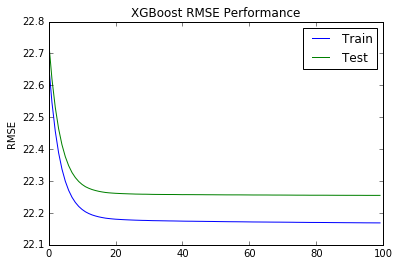

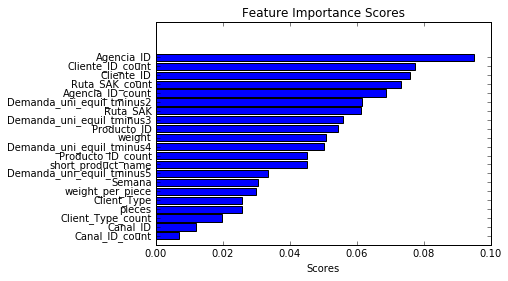

                      Feature  Importance
0                  Agencia_ID    0.094961
1            Cliente_ID_count    0.077550
2                  Cliente_ID    0.075909
3              Ruta_SAK_count    0.073164
4            Agencia_ID_count    0.068896
5   Demanda_uni_equil_tminus2    0.061630
6                    Ruta_SAK    0.061186
7   Demanda_uni_equil_tminus3    0.056046
8                 Producto_ID    0.054402
9                      weight    0.050902
10  Demanda_uni_equil_tminus4    0.050308
11          Producto_ID_count    0.045231
12         short_product_name    0.045199
13  Demanda_uni_equil_tminus5    0.033622
14                     Semana    0.030586
15           weight_per_piece    0.029823
16                Client_Type    0.025886
17                     pieces    0.025808
18          Client_Type_count    0.019841
19                   Canal_ID    0.012111
20             Canal_ID_count    0.006941

Model building complete!
Time Elapsed: 2359.11299992 seconds
Complete!


In [13]:
print "4. Fitting data to model..."
model_xgb, cv_score, feature_importances, time_elapsed = fit_model_xgb(model_xgb, y_train, X_train, y_validation, X_validation, column_names)
print "Complete!"

### Generate predictions for test data

In [14]:
def generate_test_predictions(model, test):
    """ Takes fit XGBOOST model and test data as inputs. 
        Generates and returns model predictions on test data.
    """
    predictions = np.expm1(model.predict(test.values))
    return predictions  

In [15]:
print "5. Generating test set predictions..."
test_predictions = generate_test_predictions(model_xgb, test)  
print "Complete!"

5. Generating test set predictions...
Complete!


### Write predictions to CSV

In [16]:
def generate_submission_CSV_predictions(predictions, cv_score, model_name, cv_index): 
    """ Takes predictions, validation RMSLE score, string of model name, and index used for validation set as inputs. 
        Writes test predictions to CSV file.
    """             
    # Create dataframe with test predictions
    df = pd.DataFrame(predictions, dtype = float, columns = ['Demanda_uni_equil'])      
    
    # Write to csv
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/submissions')  
    name = 'submission_' + model_name + '_' + 'Semana_' + str(cv_index) + '_' + 'cv_score_' + str(round(cv_score, 4)) + '_' + 'LB_score_' + '.csv'
    df.to_csv(name, index = True, header = True, index_label = 'id')
    os.chdir('D:/OneDrive/Documents/Kaggle/Grupo Bimbo Inventory Demand/data')  

In [17]:
print "6. Writing predictions to CSV..." 
generate_submission_CSV_predictions(test_predictions, cv_score, model_name = 'xgb', cv_index = cv_index)

6. Writing predictions to CSV...


### Process complete!